In [35]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import numpy as np
import matplotlib.pyplot as plt

holo_cube = np.load('../shampoo/holo_cube.npy')
med = np.load('../shampoo/median.npy')

kwargs = dict(origin='lower', interpolation='nearest',
              cmap=plt.cm.viridis)

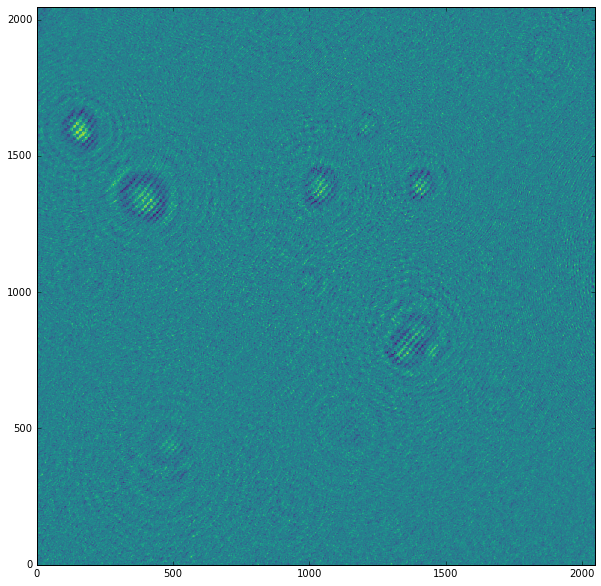

In [233]:
%matplotlib inline
def plot(array):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(array, **kwargs)
    plt.show()
h105 = holo_cube[104] - med
plot(h105)

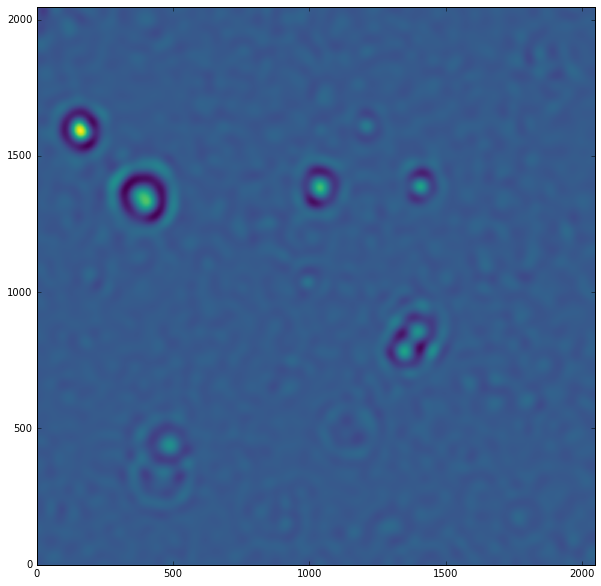

In [234]:
from pyfftw.interfaces.scipy_fftpack import fft2, ifft2
from astropy.convolution import convolve_fft, MexicanHat2DKernel, Gaussian2DKernel, Ring2DKernel
from scipy.ndimage import gaussian_filter

conv_small = convolve_fft(h105, MexicanHat2DKernel(25), fftn=fft2, ifftn=ifft2)

plot(conv_small)

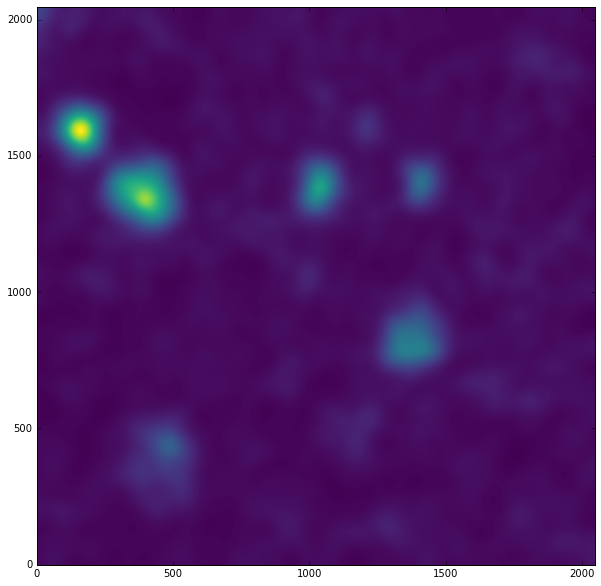

In [235]:
smooth_abs_conv = gaussian_filter(np.abs(conv_small), 30)
plot(smooth_abs_conv)

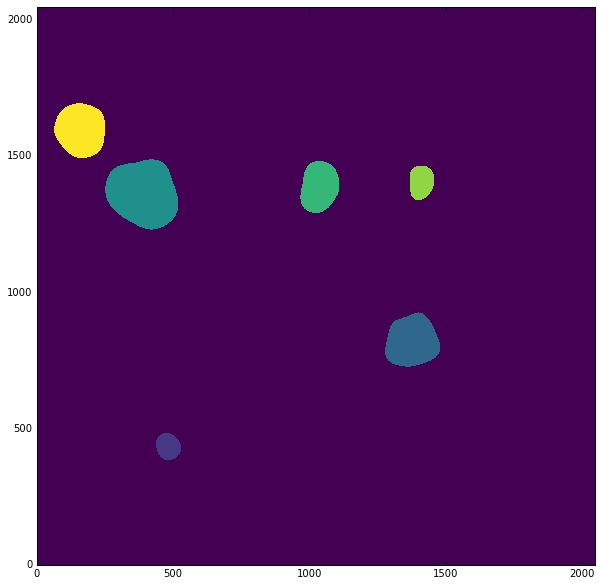

In [237]:
from skimage.filters import threshold_otsu, threshold_yen
from skimage.measure import label, regionprops

thresh = threshold_otsu(smooth_abs_conv)

masked = np.ones_like(conv_small)
masked[smooth_abs_conv <= thresh] = 0

label_image = label(masked)
plot(label_image)

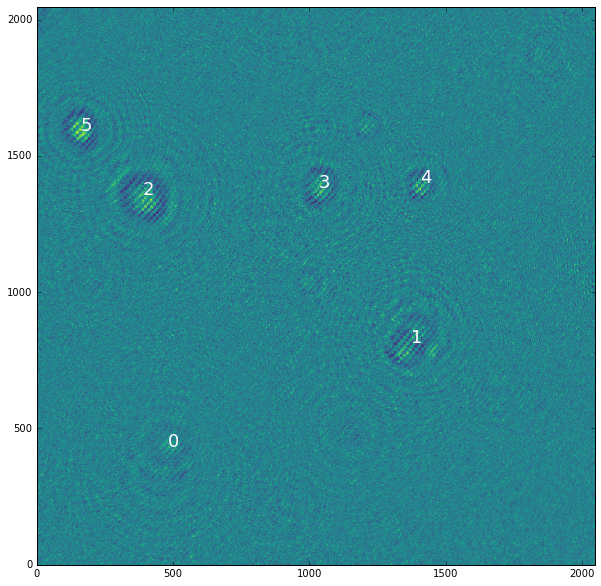

In [238]:
regions = regionprops(label_image, smooth_abs_conv)
centroids = [region.weighted_centroid for region in regions]

def plot_centroids(array, centroids):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array, **kwargs)
    for i, centroid in enumerate(centroids):
        ax.text(centroid[1], centroid[0], '{0}'.format(i), fontdict=dict(color='w', size=18))
    plt.show()

plot_centroids(h105, centroids)

In [240]:

import time
start = time.time()
positions = []
holo = holo_cube[100, ...]
median_sub_holo = holo - med
conv_holo = convolve_fft(median_sub_holo, MexicanHat2DKernel(25),
                         fftn=fft2, ifftn=ifft2)
smooth_abs_conv = gaussian_filter(np.abs(conv_holo), 30)


thresh = threshold_otsu(smooth_abs_conv)

masked = np.ones_like(smooth_abs_conv)
masked[smooth_abs_conv <= thresh] = 0

label_image = label(masked)
regions = regionprops(label_image, smooth_abs_conv)

end = time.time()
print(end-start)

5.672808885574341


In [328]:
positions[:, 1].ptp()/positions[:, 0].ptp()

0.084316302642113025

/Users/bmmorris/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 983 but corresponding boolean dimension is 1


N labels: 1


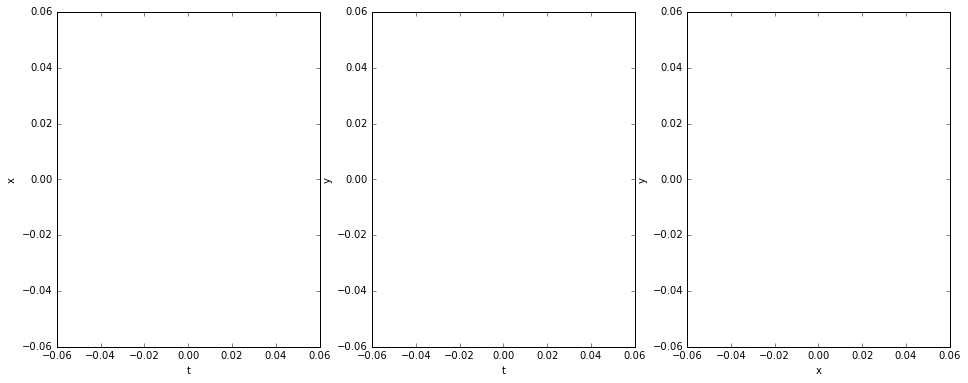

In [412]:
positions = np.load('../shampoo/positions_2d.npy')
#X = positions.copy()
#X = X[:, 0:4]
#X[:, 0] *= positions[:, 1].ptp()/positions[:, 0].ptp()
# plt.plot(positions[:, 1:3], '.')

r = np.sqrt(positions[:, 1]**2 + positions[:, 2]**2)
X = np.hstack([positions[:, 0], r])
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=150, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#print(labels)

unique_labels = set(labels)
print("N labels: {0}".format(len(unique_labels)))
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
for k, col in zip(unique_labels, colors):
    col = plt.cm.Spectral(np.random.rand())
    class_member_mask = (labels == k)
    xy = positions[class_member_mask & core_samples_mask]
    #print(xy)
#     plt.plot(xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
    ax[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
               markeredgecolor='k', markersize=14)
    ax[1].plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=col,
               markeredgecolor='k', markersize=14)
    ax[2].plot(xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
               markeredgecolor='k', markersize=14)
    
    ax[0].set(xlabel='t', ylabel='x')
    ax[1].set(xlabel='t', ylabel='y')
    ax[2].set(xlabel='x', ylabel='y')

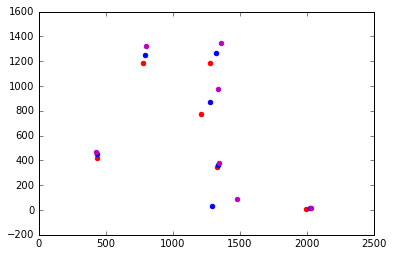

In [355]:
#fig, ax = plt.subplots(figsize=(14, 6))
fig, ax = plt.subplots()

p1 = positions[positions[:, 0] == 101, 1:3]
p2 = positions[positions[:, 0] == 102, 1:3]
p3 = positions[positions[:, 0] == 103, 1:3]

for p, c in zip([p1, p2, p3], ['r', 'b', 'm']):
    for p_i in p:
        ax.scatter(*p_i, color=c)

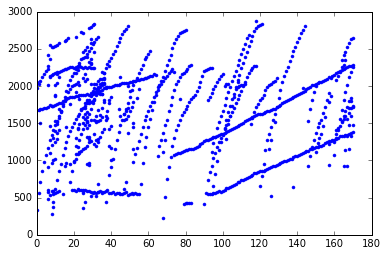

In [373]:
#plt.hist(positions[:, 3], log=True)
plt.plot(positions[:, 0], r, '.')

In [375]:
>>> # Create a signal with only 2 useful dimensions
>>> x1 = np.random.normal(size=100)
>>> x2 = np.random.normal(size=100)
>>> x3 = x1 + x2
>>> X = np.c_[x1, x2, x3]

>>> from sklearn import decomposition
>>> pca = decomposition.PCA()
>>> pca.fit(X)
#PCA(copy=True, iterated_power=4, n_components=None, random_state=None,
#  svd_solver='auto', tol=0.0, whiten=False)
>>> print(pca.explained_variance_)  
#[  2.18565811e+00   1.19346747e+00   8.43026679e-32]

>>> # As we can see, only the 2 first components are useful
>>> pca.n_components = 2
>>> X_reduced = pca.fit_transform(X)
>>> X_reduced.shape
#(100, 2)

[  2.66551672e+00   9.45734736e-01   2.24183472e-32]


(100, 2)

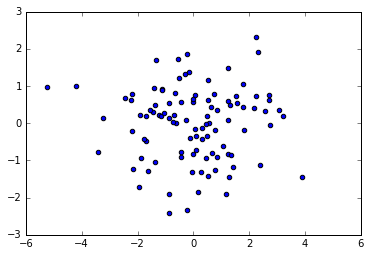

In [381]:
plt.scatter(X_reduced[:,0], X_reduced[:,1])

In [404]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(positions)
print(pca.explained_variance_)

pca.n_components = 3
X_reduced = pca.fit_transform(positions[:, 0:3])

[  3.78878296e+05   3.42296140e+05   2.53669603e+03   1.07864427e-05
   1.24470606e-07]


N labels: 20


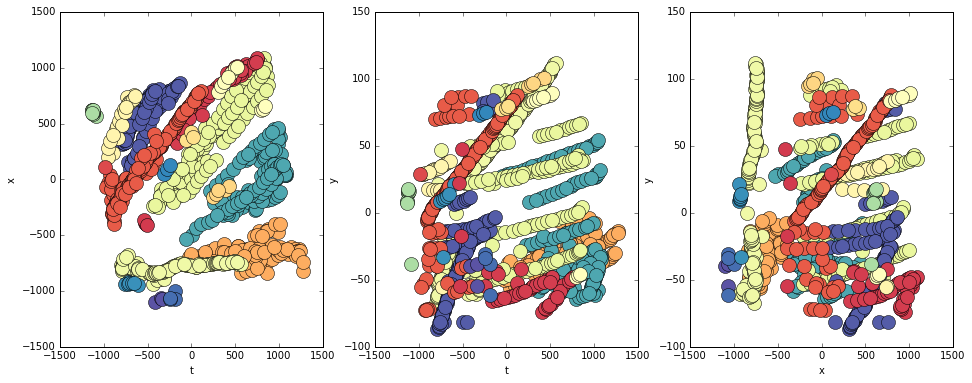

In [405]:
db = DBSCAN(eps=90, min_samples=3).fit(X_reduced)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#print(labels)

unique_labels = set(labels)
print("N labels: {0}".format(len(unique_labels)))
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
for k, col in zip(unique_labels, colors):
    col = plt.cm.Spectral(np.random.rand())
    class_member_mask = (labels == k)
    xy = X_reduced[class_member_mask & core_samples_mask]
    #print(xy)
#     plt.plot(xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
    ax[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
               markeredgecolor='k', markersize=14)
    ax[1].plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=col,
               markeredgecolor='k', markersize=14)
    ax[2].plot(xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
               markeredgecolor='k', markersize=14)
    
    ax[0].set(xlabel='t', ylabel='x')
    ax[1].set(xlabel='t', ylabel='y')
    ax[2].set(xlabel='x', ylabel='y')

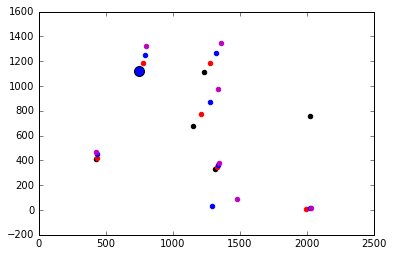

In [432]:
p0 = positions[positions[:, 0] == 100, 1:3]
p1 = positions[positions[:, 0] == 101, 1:3]
p2 = positions[positions[:, 0] == 102, 1:3]
p3 = positions[positions[:, 0] == 103, 1:3]

for p, c in zip([p0, p1, p2, p3], ['k', 'r', 'b', 'm']):
    for p_i in p:
        plt.scatter(*p_i, color=c)
        
plt.scatter(p0[1,0], p0[1,1], s=100)

In [444]:
n_closest = 2

links = []
start_position = p0[1]
time_list = [p1, p2, p3]
for i in range(len(time_list)):
    distances = np.sqrt((time_list[i][:, 0] - start_position[0])**2 + (time_list[i][:, 1] - start_position[1])**2)
    min_inds = np.argsort(distances)[:n_closest]
    links.append(min_inds)

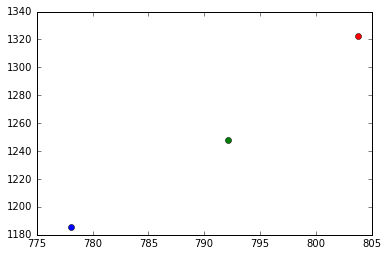

In [445]:
for link, p in zip(links, [p1, p2, p3]):
    x = p[link[0], 0]
    y = p[link[0], 1]
    plt.plot(x, y, 'o')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/sklearn/neighbors/graph.py:37: DeprecationWarning:

The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.

/Users/bmmorris/anaconda/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:443: UserWarning:

the number of connected components of the connectivity matrix is 29 > 1. Completing it to avoid stopping the tree early.



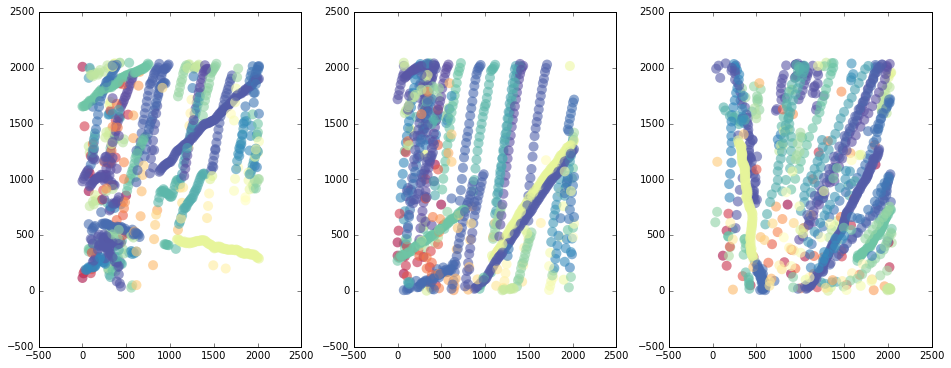

In [748]:
X = positions[:, 0:3].copy()
X[:, 0] *= positions[:, 1].ptp()/positions[:, 0].ptp()

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

linkages = ('average', 'complete', 'ward')

n_clusters = 150
knn_graph = kneighbors_graph(X, n_neighbors=3, metric='euclidean') # n_neighbors=3,  #, include_self=False
                             #mode='distance' # mode='connectivity'
model = AgglomerativeClustering(linkage=linkages[0],
                                connectivity=knn_graph,
                                n_clusters=n_clusters,
                                #affinity='cosine') 
                                affinity='euclidean')

# Affinity parameter is a `metric`: 
# https://en.wikipedia.org/wiki/Hierarchical_clustering#Metric

model.fit(X)
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

kwargs = dict(s=100, alpha=0.6, edgecolor='none', cmap=plt.cm.Spectral,
              c=model.labels_)
ax[0].scatter(X[:, 0], X[:, 1], **kwargs)

ax[1].scatter(X[:, 0], X[:, 2], **kwargs)

ax[2].scatter(X[:, 1], X[:, 2], **kwargs)

#for axis in ax:
#    axis.set_xlim([0, 2048])
#    axis.set_ylim([0, 2048])

150
n clusters with >10 points: 21


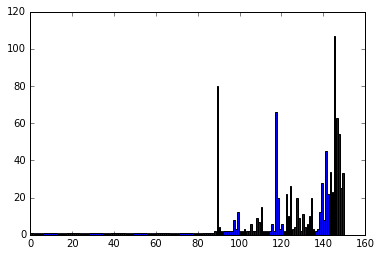

In [749]:
labels = model.labels_
ll = labels.tolist()
counter = 0
for l in set(ll):
    plt.bar(l, ll.count(l))
    if ll.count(l) > 10:
        counter += 1
print(len(set(ll)))
print("n clusters with >10 points: {0}".format(counter))

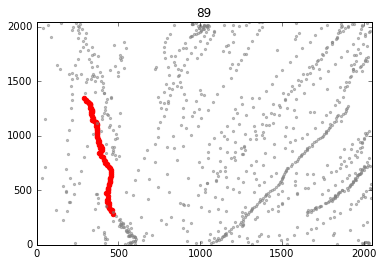

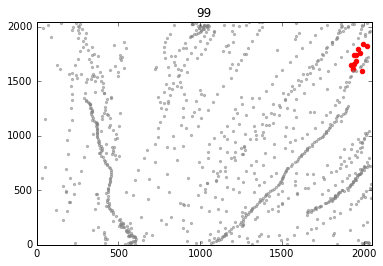

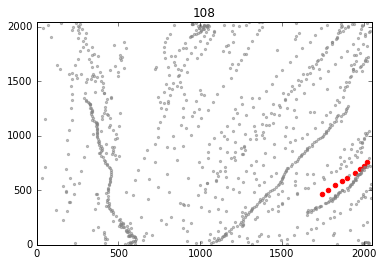

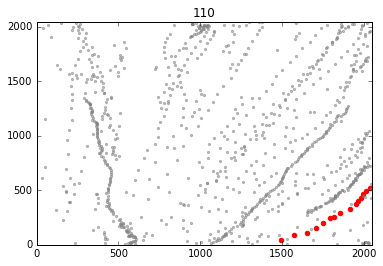

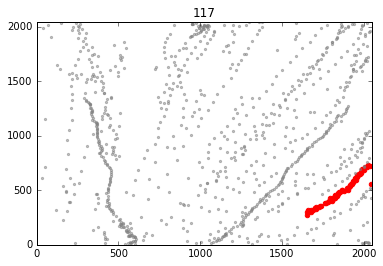

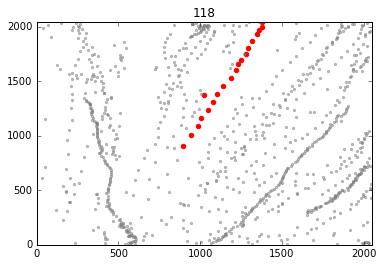

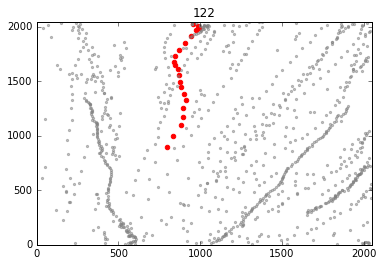

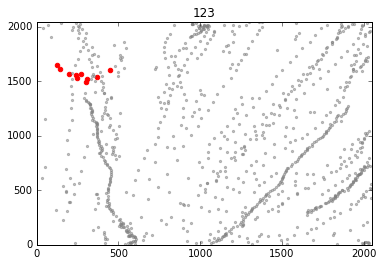

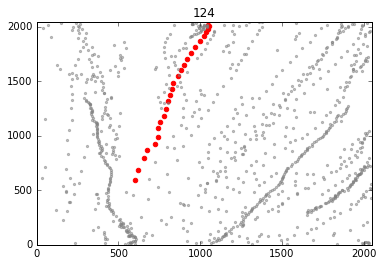

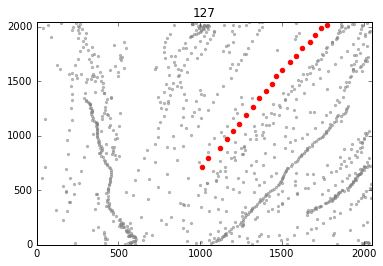

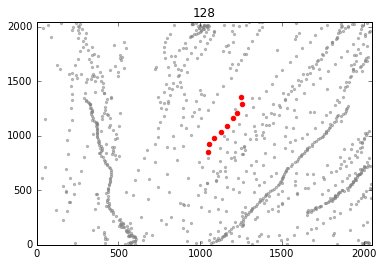

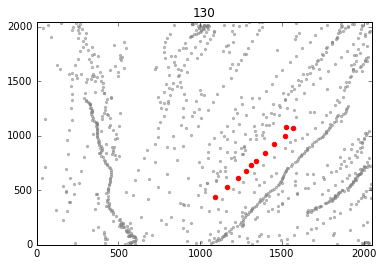

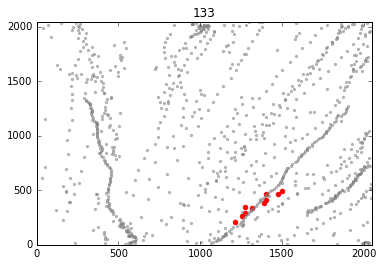

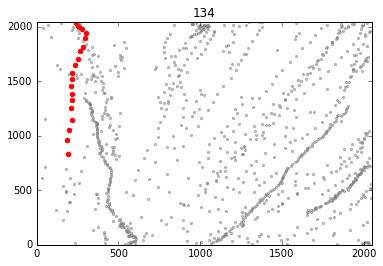

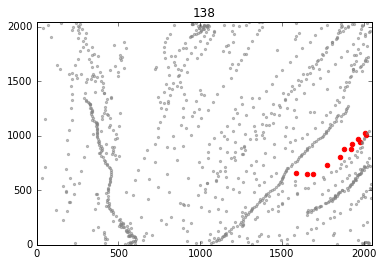

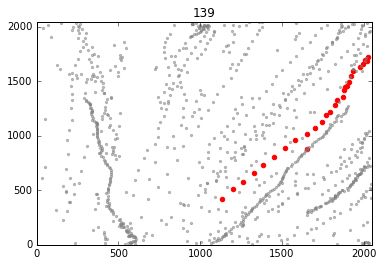

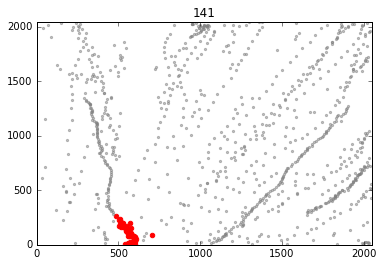

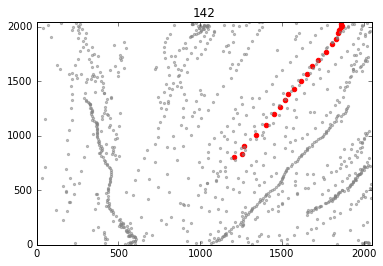

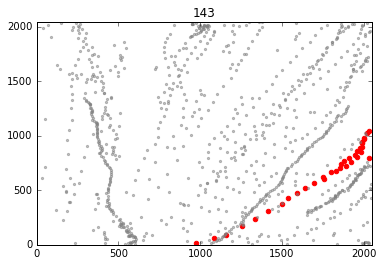

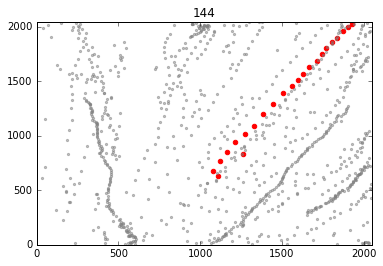

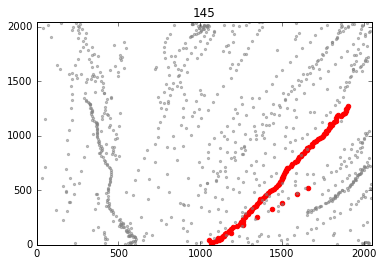

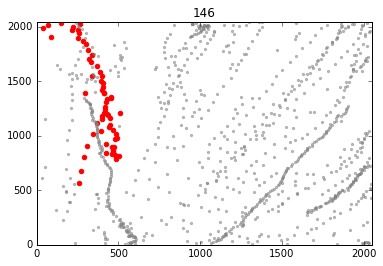

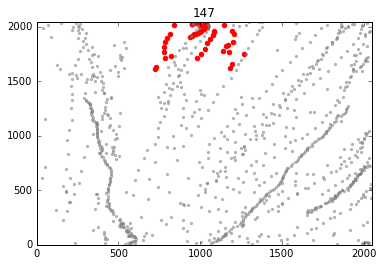

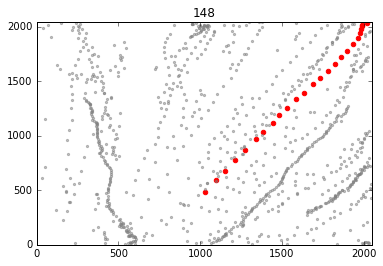

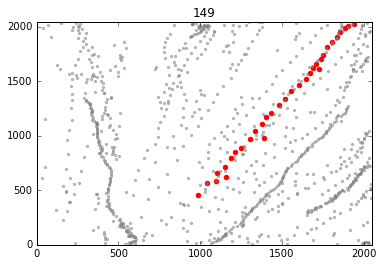

In [750]:
for i, l in enumerate(set(ll)):
    this_label = labels == l
    if np.count_nonzero(this_label) > 8:
        plt.scatter(X[this_label, 1], X[this_label, 2], color='r')
        plt.scatter(X[~this_label, 1], X[~this_label, 2], color='gray', alpha=0.5, s=5)
        plt.xlim((0, 2048))
        plt.ylim((0, 2048))
        plt.title("{0}".format(i))
        plt.show()